In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from datetime import datetime
import numpy as np
import warnings
import ml_metrics as metrics
from sklearn.metrics import r2_score
from datetime import datetime,timedelta
warnings.filterwarnings("ignore")

# Начальные сведения

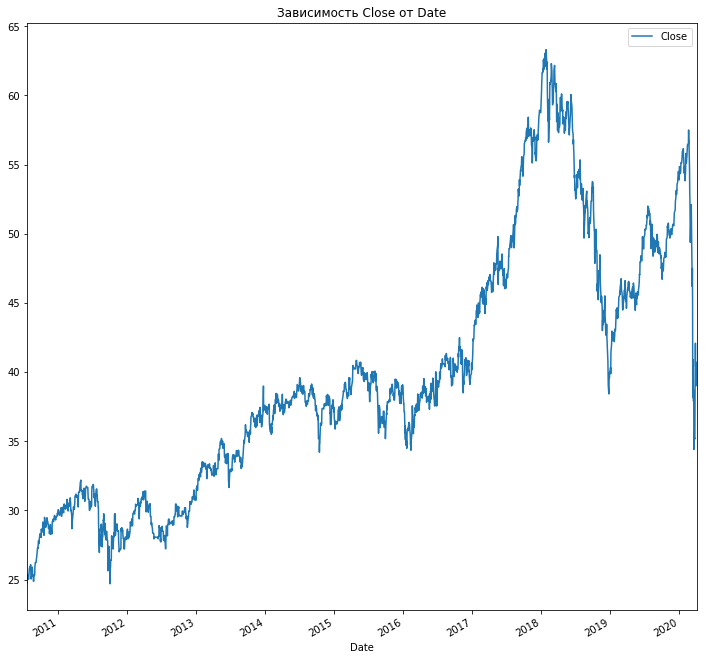

In [2]:
path1 = './data/AADR.csv'
df = pd.read_csv(path1)
predict_column = "Close"
df.Date = pd.to_datetime(df.Date)
fig, ax = plt.subplots(ncols=1, nrows = 1, figsize= (12,12))
ax.set_title(f'Зависимость {predict_column} от Date')
df.plot(x = "Date", y =predict_column , ax = ax)
plt.show()

In [3]:
tsclose = df.Close
tsclose.index = df.Date

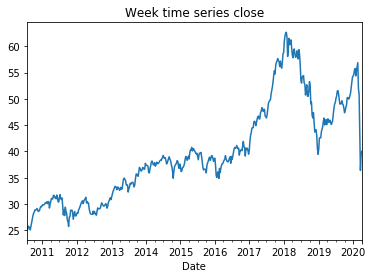

In [4]:
wtsclose = tsclose.resample('w',how='mean')
wtsclose.plot(title='Week time series close')
plt.show()

Разложение ряда на состовляющие

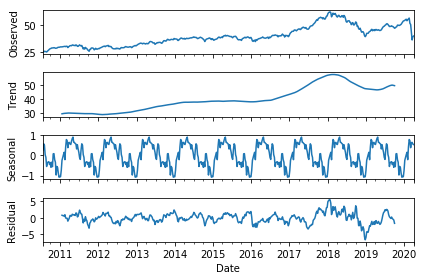

In [5]:
_ = sm.tsa.seasonal_decompose(wtsclose).plot()


Из сезонной состовляющей можно сделать вывод о том, что она годовая s = 52 (В году 52 недели)

# Определение параметров модели SARIMA

### Параметры интеграции

In [6]:
def make_adf_test(ts):
    test = sm.tsa.adfuller(ts)
    print(f'adf: {test[0]}')
    print(f'p-value: {test[1]}')
    print(f'Critical values: {test[4]}')
    if test[0]> test[4]['5%']: 
        print('есть единичные корни, ряд не стационарен')
    else:
        print('единичных корней нет, ряд стационарен')

In [7]:
make_adf_test(wtsclose)

adf: -1.8281087603108892
p-value: 0.36659844774811945
Critical values: {'1%': -3.44336554668393, '5%': -2.867280279529963, '10%': -2.5698273512400744}
есть единичные корни, ряд не стационарен


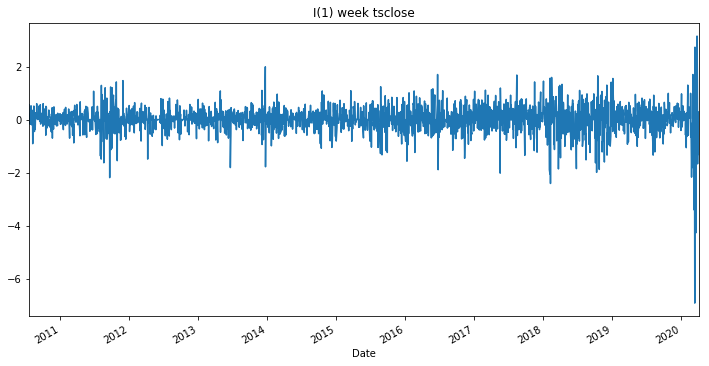

In [8]:
wdiff1 = tsclose.diff(periods=1).dropna()
wdiff1.plot(figsize=(12,6),title='I(1) week tsclose')
plt.show()

In [9]:
make_adf_test(wdiff1)

adf: -18.525888942775424
p-value: 2.10595446710592e-30
Critical values: {'1%': -3.4330405929799293, '5%': -2.862728675299008, '10%': -2.5674027803295183}
единичных корней нет, ряд стационарен


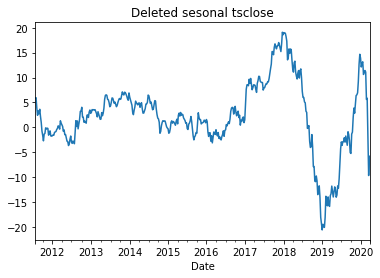

In [10]:
w_sesonal = wtsclose.diff(periods=52).dropna()
w_sesonal.plot(title = 'Deleted sesonal tsclose')
plt.show()

In [11]:
make_adf_test(w_sesonal)

adf: -2.321875692188301
p-value: 0.16500965469083656
Critical values: {'1%': -3.444932949082776, '5%': -2.867969899953726, '10%': -2.57019489663276}
есть единичные корни, ряд не стационарен


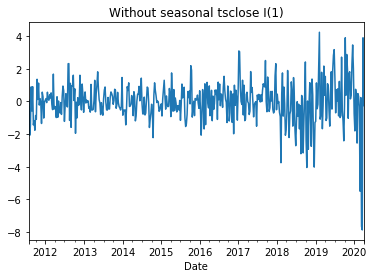

In [13]:
wdiff1_sesonal = w_sesonal.diff(periods=1).dropna()
wdiff1_sesonal.plot(title = 'Without seasonal tsclose I(1)')
plt.show()

In [14]:
make_adf_test(wdiff1_sesonal)

adf: -10.246111905481206
p-value: 4.6131112039476986e-18
Critical values: {'1%': -3.444932949082776, '5%': -2.867969899953726, '10%': -2.57019489663276}
единичных корней нет, ряд стационарен


### Параметры p, q, P, D

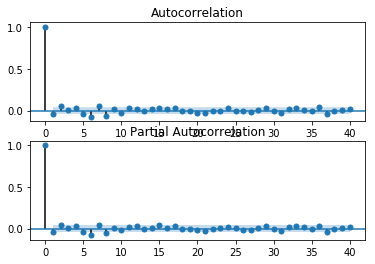

In [15]:
fig, axs = plt.subplots(2,1)
pacf = sm.tsa.pacf(wdiff1)
acf = sm.tsa.acf(wdiff1)
_ = sm.graphics.tsa.plot_acf(wdiff1,ax=axs[0],lags=40)
_ = sm.graphics.tsa.plot_pacf(wdiff1,ax=axs[1],lags=40)

In [18]:
pacf = sm.tsa.pacf(wdiff1_sesonal,nlags=104)
acf = sm.tsa.acf(wdiff1_sesonal,nlags=104)
temp = [pacf[51 + 52*t] for t in [0,1]], [acf[51 + 52*t] for t in [0,1]]
print(f'pacf period: {temp[0]} | acf period: {temp[1]}')


pacf period: [-0.1347026705552312, -0.0792743475641203] | acf period: [-0.10197519407626442, 0.03026148062788601]


In [19]:
p,d,q = (1,1,1)
P,D,Q,s = (1,1,1,52)

# Построение модели

In [21]:
model = sm.tsa.SARIMAX(wtsclose,order=(p,q,d),seasonal_order=(P,Q,D,s))
model_fit = model.fit(disp=0,enforce_stationarity=True)

## Предсказание по модели

In [23]:
n = wtsclose.shape[0]
pred = model_fit.predict(start=n-5,end=n+2)
last_date = tsclose.index[-1]
# index_pred = [last_date + timedelta(days=i) for i in range(pred.shape[0])]
# pred.index=index_pred

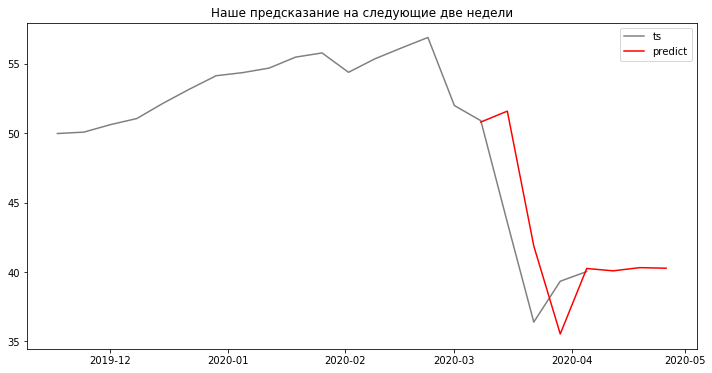

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.set_title('Наше предсказание на следующие двe недели')
ax = plt.plot(wtsclose[-21:],color='grey',label='ts')
ax = plt.plot(pred, color='red',label='predict')
plt.legend()
plt.show()

## Анализ полученной модели

In [26]:
i_split = wtsclose.shape[0]//2 + 1
X_train = wtsclose[:-30]
X_test = wtsclose[-30:]
history = [x for x in X_train]
predictions = []
for x_test in X_test:
    model = sm.tsa.SARIMAX(history,order=(p,d,q),seasonal_order=(P,D,Q,s))
    model_fit = model.fit(disp=0)
    n = len(history)
    pred = model_fit.predict(start=n,end=n)
#     print(pred)
    predictions.extend(pred)
    history.append(x_test)



In [2]:
r2_error = r2_score(predictions,X_test) 
mse_error = metrics.mse(X_test,predictions)
mae_error = metrics.mae(X_test,predictions)

print(f'Ошибка на одну неделю\nR2: {r2_error} | MSE: {mse_error} | MAE {mae_error}')


Ошибка на одну неделю
R2: 0.7679341867617295 | MSE: 5.73218981683044 | MAE 1.3815974858414373


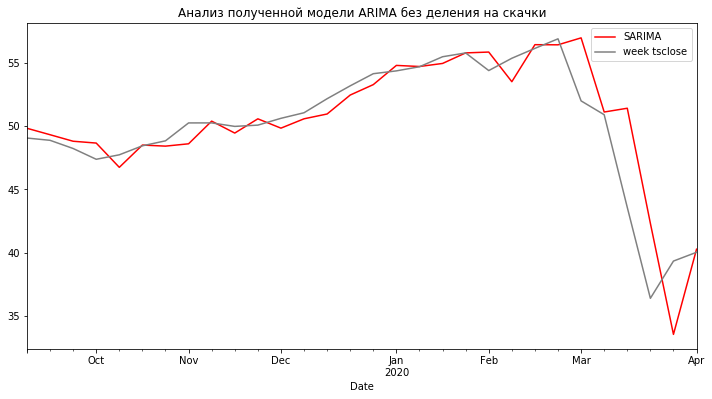

In [37]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.set_title('Анализ полученной модели ARIMA без деления на скачки')
predictions = pd.Series(predictions, index = X_test.index)

predictions.plot(color = 'red',label='SARIMA')
X_test.plot(color='grey', label='week tsclose')

plt.legend()
plt.show() 